In [31]:
import pandas as pd
import numpy as np
import json
import re
import xml.etree.ElementTree as ET
from typing import Dict, List, Tuple, Optional
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import random
from dataclasses import dataclass
from enum import Enum

In [32]:
import google.generativeai as genai
from google.colab import userdata
import time

In [33]:
import concurrent.futures

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
import os

base_dir = '/content/drive/MyDrive/System_Simulation'
subdirs = ['svgs', 'logs', 'graphics']

os.makedirs(base_dir, exist_ok=True)

for subdir in subdirs:
    os.makedirs(os.path.join(base_dir, subdir), exist_ok=True)

In [36]:
class TemplateVersion(Enum):
    V1 = "v1"
    V2 = "v2"
    V3 = "v3"

class Category(Enum):
    LANDSCAPE = "landscape"
    ABSTRACT = "abstract"
    FASHION = "fashion"
    UNKNOWN = "unknown"

@dataclass
class ValidationResult:
    valid: bool
    errors: List[str]
    warnings: List[str]
    byte_count: int
    element_count: int
    violation_types: List[str]

@dataclass
class SimulationMetrics:
    description: str
    category: str
    template_version: str
    prompt_length: int
    svg_byte_count: int
    constraint_compliance: bool
    validation_result: ValidationResult
    generation_time: float
    generated_svg: str # Add the new field

In [37]:

class PromptGenerator:
    """Core component for generating standardized prompts from descriptions"""

    def __init__(self, template_version: TemplateVersion = TemplateVersion.V1):
        self.template_version = template_version
        self.constraint_rules = self._load_svg_constraints()

    def _load_svg_constraints(self) -> Dict[str, any]:
        """Load SVG constraint specifications"""
        return {
            'max_bytes': 10000,
            'allowed_elements': {
                'svg', 'rect', 'circle', 'ellipse', 'line',
                'polyline', 'polygon', 'path', 'text', 'g',
                'defs', 'use', 'image', 'switch'
            },
            'forbidden_attributes': {'style', 'class'},
            'allowed_attributes': {
                'x', 'y', 'width', 'height', 'cx', 'cy', 'r', 'rx', 'ry',
                'x1', 'y1', 'x2', 'y2', 'points', 'd', 'fill', 'stroke',
                'stroke-width', 'opacity', 'transform', 'id'
            }
        }

    def generate_prompt(self, description: str, category: Optional[Category] = None) -> str:
        """Generate standardized prompt from description"""
        template = self._get_template(self.template_version)
        constraints_text = self._format_constraints()
        category_hints = self._get_category_hints(category)

        prompt = template.format(
            description=description,
            constraints=constraints_text,
            category_hints=category_hints
        )

        return prompt

    def _get_template(self, version: TemplateVersion) -> str:
        """Get prompt template by version"""
        templates = {
            TemplateVersion.V1: (
                "You are an expert in generating concise and valid SVG code according to the provided constraints. Output only the SVG code and nothing else."
                "Generate an SVG image that represents: {description}. "
                "Important constraints: {constraints}"
            ),
            TemplateVersion.V2: (
                "You are an expert in generating concise and valid SVG code according to the provided constraints. Output only the SVG code and nothing else."
                "Create SVG code for: {description}. "
                "Requirements: {constraints}. "
                "Category optimization: {category_hints}"
            ),
            TemplateVersion.V3: (
                "You are an expert in generating concise and valid SVG code according to the provided constraints. Output only the SVG code and nothing else."
                "SVG Generation Task:\n"
                "Description: {description}\n"
                "Constraints: {constraints}\n"
                "Optimize for: {category_hints}\n"
                "Output only valid SVG code."
            )
        }
        return templates.get(version, templates[TemplateVersion.V1])

    def _format_constraints(self) -> str:
        """Format constraints into readable text"""
        constraints = [
            f"Maximum {self.constraint_rules['max_bytes']} bytes",
            f"Only use elements: {', '.join(sorted(self.constraint_rules['allowed_elements']))}",
            "No CSS styling or external references",
            "No rasterized image data"
        ]
        return "; ".join(constraints)

    def _get_category_hints(self, category: Optional[Category]) -> str:
        """Get category-specific optimization hints"""
        hints = {
            Category.LANDSCAPE: "natural scenes, outdoor environments, horizon lines",
            Category.ABSTRACT: "geometric shapes, artistic patterns, non-representational forms",
            Category.FASHION: "clothing items, accessories, style elements",
            Category.UNKNOWN: "general visual representation"
        }
        return hints.get(category, hints[Category.UNKNOWN])


In [38]:

class SVGConstraintValidator:
    """Validates SVG code against competition constraints"""

    def __init__(self):
        self.max_bytes = 10000
        self.allowed_elements = {
            'svg', 'rect', 'circle', 'ellipse', 'line',
            'polyline', 'polygon', 'path', 'text', 'g',
            'defs', 'use', 'image', 'switch'
        }
        self.forbidden_attributes = {'style', 'class'}
        self.allowed_attributes = {
            'x', 'y', 'width', 'height', 'cx', 'cy', 'r', 'rx', 'ry',
            'x1', 'y1', 'x2', 'y2', 'points', 'd', 'fill', 'stroke',
            'stroke-width', 'opacity', 'transform', 'id', 'viewBox'
        }

    def validate_svg(self, svg_code: str) -> ValidationResult:
        """Validate SVG against competition constraints"""
        errors = []
        warnings = []
        violation_types = []

        # Byte count check
        byte_count = len(svg_code.encode('utf-8'))
        if byte_count > self.max_bytes:
            errors.append(f"SVG exceeds byte limit: {byte_count} > {self.max_bytes}")
            violation_types.append("byte_limit")

        # Parse SVG
        try:
            root = ET.fromstring(svg_code)
            element_count = self._count_elements(root)

            # Element validation
            invalid_elements = self._validate_elements(root)
            if invalid_elements:
                errors.extend([f"Invalid element: {elem}" for elem in invalid_elements])
                violation_types.append("invalid_elements")

            # Attribute validation
            invalid_attrs = self._validate_attributes(root)
            if invalid_attrs:
                errors.extend([f"Invalid attribute: {attr}" for attr in invalid_attrs])
                violation_types.append("invalid_attributes")

            # CSS check
            if self._has_css_styling(svg_code):
                errors.append("CSS styling detected")
                violation_types.append("css_styling")

            # External references check
            if self._has_external_refs(svg_code):
                errors.append("External references detected")
                violation_types.append("external_refs")

        except ET.ParseError as e:
            errors.append(f"XML parsing error: {str(e)}")
            violation_types.append("parse_error")
            element_count = 0

        return ValidationResult(
            valid=len(errors) == 0,
            errors=errors,
            warnings=warnings,
            byte_count=byte_count,
            element_count=element_count,
            violation_types=violation_types
        )

    def _count_elements(self, root) -> int:
        """Count total elements in SVG"""
        count = 1  # Root element
        for child in root.iter():
            if child != root:
                count += 1
        return count

    def _validate_elements(self, root) -> List[str]:
        """Validate all elements are allowed"""
        invalid = []
        for elem in root.iter():
            tag = elem.tag.split('}')[-1] if '}' in elem.tag else elem.tag
            if tag not in self.allowed_elements:
                invalid.append(tag)
        return list(set(invalid))

    def _validate_attributes(self, root) -> List[str]:
        """Validate all attributes are allowed"""
        invalid = []
        for elem in root.iter():
            for attr in elem.attrib:
                clean_attr = attr.split('}')[-1] if '}' in attr else attr
                if clean_attr in self.forbidden_attributes:
                    invalid.append(clean_attr)
        return list(set(invalid))

    def _has_css_styling(self, svg_code: str) -> bool:
        """Check for CSS styling"""
        css_patterns = [
            r'<style[^>]*>.*?</style>',
            r'style\s*=',
            r'class\s*='
        ]
        for pattern in css_patterns:
            if re.search(pattern, svg_code, re.IGNORECASE | re.DOTALL):
                return True
        return False

    def _has_external_refs(self, svg_code: str) -> bool:
        """Check for external references"""
        external_patterns = [
            r'href\s*=\s*["\']http',
            r'src\s*=\s*["\']http',
            r'url\s*\(["\']http'
        ]
        for pattern in external_patterns:
            if re.search(pattern, svg_code, re.IGNORECASE):
                return True
        return False


In [39]:
class ModelLLM:
    """Interacts with an external LLM API to generate SVG code."""

    def __init__(self, model_name: str = 'gemini-2.5-flash'):
        """Initializes the LLM with a model name.

        Args:
            model_name: The name of the LLM model to use.
        """
        try:
            GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
            genai.configure(api_key=GOOGLE_API_KEY)
            self.model = genai.GenerativeModel(model_name)
        except Exception as e:
            print(f"Error initializing Google Generative AI: {e}")
            self.model = None

    def predict(self, prompt: str) -> str:
        """Generates SVG code using the LLM based on the given prompt.

        Args:
            prompt: The text prompt for generating SVG.

        Returns:
            A string containing the generated SVG code, or an empty string if an error occurred.
        """
        if not self.model:
            print("LLM model not initialized. Cannot generate SVG.")
            return ""

        try:
            # Add a system instruction to ensure the model outputs only SVG
            response = self.model.generate_content(
                prompt,
                safety_settings={
                    'HARM_CATEGORY_HATE_SPEECH': 'BLOCK_NONE',
                    'HARM_CATEGORY_DANGEROUS_CONTENT': 'BLOCK_NONE',
                    'HARM_CATEGORY_SEXUALLY_EXPLICIT': 'BLOCK_NONE',
                    'HARM_CATEGORY_HARASSMENT': 'BLOCK_NONE',
                }
            )

            # Extract the text from the response
            if response and response.text:
                # Simple attempt to clean up potential extra text before or after SVG
                svg_match = re.search(r'(<svg.*?</svg>)', response.text, re.DOTALL)
                if svg_match:
                    print(f"Successfully generated SVG with prompt: {prompt}")
                    return svg_match.group(1).strip()
                else:
                    print(f"Warning: Could not find SVG in response: {response.text[:200]}...")
                    return ""
            else:
                print("LLM response was empty or invalid.")
                return ""

        except Exception as e:
            print(f"Error during LLM prediction: {e}")
            # Add a small delay before retrying or failing
            time.sleep(1)
            return ""

In [41]:
class CategoryDetector:
    """Detects category from description text"""

    def __init__(self):
        self.category_keywords = {
            Category.LANDSCAPE: [
                'forest', 'mountain', 'river', 'lake', 'tree', 'sky', 'cloud',
                'sunset', 'sunrise', 'field', 'grass', 'beach', 'ocean', 'hill'
            ],
            Category.ABSTRACT: [
                'pattern', 'geometric', 'shape', 'abstract', 'design', 'form',
                'spiral', 'curve', 'line', 'composition', 'artistic', 'modern'
            ],
            Category.FASHION: [
                'dress', 'shirt', 'pants', 'shoe', 'hat', 'jacket', 'clothing',
                'outfit', 'style', 'fashion', 'wear', 'garment', 'accessory'
            ]
        }

    def detect_category(self, description: str) -> Category:
        """Detect category from description"""
        description_lower = description.lower()

        scores = {}
        for category, keywords in self.category_keywords.items():
            score = sum(1 for keyword in keywords if keyword in description_lower)
            scores[category] = score

        if max(scores.values()) > 0:
            return max(scores, key=scores.get)

        return Category.UNKNOWN

In [42]:

# Example usage and main simulation function
def load_sample_descriptions() -> List[str]:
    """Load sample descriptions for simulation"""
    # This would typically load from train.csv
    sample_descriptions = [
        "a purple forest at dusk",
        "geometric abstract pattern with circles",
        "red dress with flowing fabric",
        "mountain landscape with snow peaks",
        "modern art composition with triangles",
        "blue jeans and white shirt",
        "sunset over calm lake",
        "spiral design in bright colors",
        "elegant evening gown",
        "forest path with tall trees",
        "abstract wave pattern",
        "casual summer outfit",
        "beach scene with palm trees",
        "minimalist geometric design",
        "vintage coat with buttons",
        "cloudy sky over green hills",
        "colorful mandala pattern",
        "sports jacket and sneakers",
        "river flowing through valley",
        "artistic brush strokes",

    ]
    return sample_descriptions


In [43]:
class SimulationRunner:
    """Main simulation orchestrator"""

    def __init__(self):
        self.prompt_generator = None
        self.svg_validator = SVGConstraintValidator()
        self.llm_generator = ModelLLM() # Initialize the LLM
        self.category_detector = CategoryDetector()
        self.metrics = []

    def run_simulation(self, descriptions: List[str], template_versions: List[TemplateVersion]) -> List[SimulationMetrics]:
        """Run complete simulation across descriptions and template versions"""
        all_metrics = []

        if not self.llm_generator.model:
            print("LLM model not initialized. Skipping simulation.")
            return []

        # Use a ThreadPoolExecutor for parallel processing
        # Choose a reasonable number of workers, considering API calls are I/O bound
        max_workers = 5 # Example: 5 concurrent API calls

        with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
            futures = []
            for template_version in template_versions:
                print(f"Testing template version: {template_version.value}")
                self.prompt_generator = PromptGenerator(template_version)

                for i, description in enumerate(descriptions):
                    # Submit each description processing to the thread pool
                    future = executor.submit(self._process_single_description, description, template_version)
                    futures.append(future)

            # Collect results as they complete
            for i, future in enumerate(concurrent.futures.as_completed(futures)):
                if (i + 1) % 10 == 0:
                    print(f"  Completed {i+1}/{len(futures)} descriptions")
                try:
                    metrics = future.result()
                    all_metrics.append(metrics)
                except Exception as exc:
                    print(f'Description generated an exception: {exc}')

        self.metrics = all_metrics
        return all_metrics


    def _process_single_description(self, description: str, template_version: TemplateVersion) -> SimulationMetrics:
        """Process a single description through the simulation pipeline"""
        # Detect category
        category = self.category_detector.detect_category(description)

        # Generate prompt
        start_time = datetime.now()
        prompt = self.prompt_generator.generate_prompt(description, category)

        # Generate SVG using the LLM
        generated_svg = self.llm_generator.predict(prompt)

        # Validate SVG
        validation_result = self.svg_validator.validate_svg(generated_svg)
        generation_time = (datetime.now() - start_time).total_seconds()

        return SimulationMetrics(
            description=description,
            category=category.value,
            template_version=template_version.value,
            prompt_length=len(prompt),
            svg_byte_count=validation_result.byte_count,
            constraint_compliance=validation_result.valid,
            validation_result=validation_result,
            generation_time=generation_time,
            generated_svg=generated_svg # Assign the generated SVG
        )

    def generate_report(self) -> Dict:
        """Generate comprehensive simulation report"""
        if not self.metrics:
            raise ValueError("No simulation metrics available. Run simulation first.")

        df = pd.DataFrame([
            {
                'description': m.description,
                'category': m.category,
                'template_version': m.template_version,
                'prompt_length': m.prompt_length,
                'svg_byte_count': m.svg_byte_count,
                'constraint_compliance': m.constraint_compliance,
                'generation_time': m.generation_time,
                'error_count': len(m.validation_result.errors),
                'violation_types': ','.join(m.validation_result.violation_types)
            }
            for m in self.metrics
        ])

        report = {
            'summary': self._generate_summary_stats(df),
            'template_performance': self._analyze_template_performance(df),
            'category_analysis': self._analyze_category_performance(df),
            'constraint_violations': self._analyze_constraint_violations(df),
            'recommendations': self._generate_recommendations(df)
        }

        return report

    def _generate_summary_stats(self, df: pd.DataFrame) -> Dict:
        """Generate summary statistics"""
        return {
            'total_simulations': len(df),
            'overall_compliance_rate': df['constraint_compliance'].mean(),
            'average_svg_bytes': df['svg_byte_count'].mean(),
            'average_prompt_length': df['prompt_length'].mean(),
            'average_generation_time': df['generation_time'].mean(),
            'unique_categories': df['category'].nunique(),
            'template_versions_tested': df['template_version'].nunique()
        }

    def _analyze_template_performance(self, df: pd.DataFrame) -> Dict:
        """Analyze performance by template version"""
        template_stats = df.groupby('template_version').agg({
            'constraint_compliance': ['count', 'sum', 'mean'],
            'svg_byte_count': 'mean',
            'prompt_length': 'mean',
            'generation_time': 'mean',
            'error_count': 'mean'
        }).round(4)

        # Flatten the multi-level column index before converting to dictionary
        template_stats.columns = ['_'.join(col).strip() for col in template_stats.columns.values]

        return template_stats.to_dict('index')

    def _analyze_category_performance(self, df: pd.DataFrame) -> Dict:
        """Analyze performance by category"""
        category_stats = df.groupby('category').agg({
            'constraint_compliance': ['count', 'sum', 'mean'],
            'svg_byte_count': 'mean',
            'error_count': 'mean'
        }).round(4)

        # Flatten the multi-level column index before converting to dictionary
        category_stats.columns = ['_'.join(col).strip() for col in category_stats.columns.values]

        return category_stats.to_dict('index')


    def _analyze_constraint_violations(self, df: pd.DataFrame) -> Dict:
        """Analyze constraint violation patterns"""
        violations = []
        for metric in self.metrics:
            violations.extend(metric.validation_result.violation_types)

        violation_counts = pd.Series(violations).value_counts().to_dict()

        # The violation_rate_by_template might also have tuple keys if groupby().mean() results in a Series with a tuple index.
        # Let's ensure the keys are strings.
        violation_rate_by_template_series = df.groupby('template_version')['error_count'].mean()
        violation_rate_by_template_dict = {str(key): value for key, value in violation_rate_by_template_series.to_dict().items()}


        return {
            'violation_frequency': violation_counts,
            'most_common_violation': max(violation_counts, key=violation_counts.get) if violation_counts else None,
            'violation_rate_by_template': violation_rate_by_template_dict
        }

    def _generate_recommendations(self, df: pd.DataFrame) -> List[str]:
        """Generate recommendations based on simulation results"""
        recommendations = []

        # Template performance
        if not df.empty:
            compliance_by_template = df.groupby('template_version')['constraint_compliance'].mean()
            if not compliance_by_template.empty:
                best_template = compliance_by_template.idxmax()
                recommendations.append(f"Use template version {best_template} for best constraint compliance")

            # Category insights
            category_performance = df.groupby('category')['constraint_compliance'].mean()
            if not category_performance.empty:
                worst_category = category_performance.idxmin()
                recommendations.append(f"Focus optimization efforts on {worst_category} category")

            # Byte usage
            avg_bytes = df['svg_byte_count'].mean()
            if avg_bytes > 8000:
                recommendations.append("Implement byte usage optimization - average usage is high")

            # Error patterns
            high_error_templates = df[df['error_count'] > 0]['template_version'].unique()
            if len(high_error_templates) > 0:
                recommendations.append(f"Revise templates {list(high_error_templates)} to reduce constraint violations")

        return recommendations


    def visualize_results(self):
        """Generate visualization plots"""
        if not self.metrics:
            raise ValueError("No simulation metrics available. Run simulation first.")

        df = pd.DataFrame([
            {
                'template_version': m.template_version,
                'category': m.category,
                'constraint_compliance': m.constraint_compliance,
                'svg_byte_count': m.validation_result.byte_count, # Corrected access here
                'error_count': len(m.validation_result.errors)
            }
            for m in self.metrics
        ])

        if df.empty:
            print("No data to visualize.")
            return


        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # Compliance rate by template
        compliance_by_template = df.groupby('template_version')['constraint_compliance'].mean()
        if not compliance_by_template.empty:
            axes[0, 0].bar(compliance_by_template.index, compliance_by_template.values)
            axes[0, 0].set_title('Constraint Compliance Rate by Template Version')
            axes[0, 0].set_ylabel('Compliance Rate')

        # Byte usage distribution
        if not df['svg_byte_count'].empty:
            axes[0, 1].hist(df['svg_byte_count'], bins=20, alpha=0.7)
            # Corrected indentation here
            axes[0, 1].axvline(x=10000, color='red', linestyle='--', label='Byte Limit')
            axes[0, 1].set_title('SVG Byte Count Distribution')
            axes[0, 1].set_xlabel('Bytes')
            axes[0, 1].legend()

        # Category performance
        compliance_by_category = df.groupby('category')['constraint_compliance'].mean()
        if not compliance_by_category.empty:
            axes[1, 0].bar(compliance_by_category.index, compliance_by_category.values)
            axes[1, 0].set_title('Constraint Compliance by Category')
            axes[1, 0].set_ylabel('Compliance Rate')
            axes[1, 0].tick_params(axis='x', rotation=45)

        # Error count distribution
        error_dist = df['error_count'].value_counts().sort_index()
        if not error_dist.empty:
            axes[1, 1].bar(error_dist.index, error_dist.values)
            axes[1, 1].set_title('Error Count Distribution')
            axes[1, 1].set_xlabel('Number of Errors')
            axes[1, 1].set_ylabel('Frequency')

        plt.tight_layout()
        plt.show()

In [44]:
def main():
    """Main simulation execution"""
    print("Starting Drawing with LLMs System Simulation")
    print("=" * 50)

    # Load data
    descriptions = load_sample_descriptions()
    template_versions = [TemplateVersion.V1, TemplateVersion.V2, TemplateVersion.V3]

    # Initialize and run simulation
    simulator = SimulationRunner()

    print(f"Running simulation with {len(descriptions)} descriptions and {len(template_versions)} template versions")
    metrics = simulator.run_simulation(descriptions, template_versions)

    # Generate report
    print("\nGenerating simulation report...")
    report = simulator.generate_report()

    # Print summary
    print("\nSimulation Summary:")
    print("-" * 30)
    for key, value in report['summary'].items():
        print(f"{key}: {value}")

    print("\nTemplate Performance:")
    print("-" * 30)
    # Iterate through the flattened template performance dictionary
    for template, stats in report['template_performance'].items():
        print(f"{template}: {stats}")

    print("\nRecommendations:")
    print("-" * 30)
    for i, rec in enumerate(report['recommendations'], 1):
        print(f"{i}. {rec}")

    # Save results to Google Drive
    base_dir = '/content/drive/MyDrive/System_Simulation'
    svgs_dir = os.path.join(base_dir, 'svgs')
    logs_dir = os.path.join(base_dir, 'logs')
    graphics_dir = os.path.join(base_dir, 'graphics')

    # Create directories if they don't exist
    os.makedirs(svgs_dir, exist_ok=True)
    os.makedirs(logs_dir, exist_ok=True)
    os.makedirs(graphics_dir, exist_ok=True)


    # Save JSON report
    results_file_name = f"simulation_report_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
    results_file_path = os.path.join(logs_dir, results_file_name)

    with open(results_file_path, 'w') as f:
        # Convert report to JSON-serializable format
        serializable_report = {
            'summary': report['summary'],
            'template_performance': report['template_performance'], # Include template performance
            'category_analysis': report['category_analysis'],       # Include category analysis
            'constraint_violations': report['constraint_violations'], # Include constraint violations
            'recommendations': report['recommendations'],
            'timestamp': datetime.now().isoformat()
        }
        json.dump(serializable_report, f, indent=2)

    print(f"\nReport saved to: {results_file_path}")

    # Save generated SVGs
    print("\nSaving generated SVGs...")
    for i, metric in enumerate(metrics):
        if metric.generated_svg:
            # Modify filename to be more generic
            svg_file_name = f"generated_svg_{i+1}.svg"
            svg_file_path = os.path.join(svgs_dir, svg_file_name)
            try:
                with open(svg_file_path, 'w') as f:
                    f.write(metric.generated_svg)
                # print(f"  Saved {svg_file_name}") # Optional: uncomment for more detailed progress
            except Exception as e:
                print(f"  Error saving {svg_file_name}: {e}")
    print("Finished saving SVGs.")


    # Save generated visualizations
    print("\nGenerating and saving visualizations...")
    if simulator.metrics:
        df = pd.DataFrame([
            {
                'template_version': m.template_version,
                'category': m.category,
                'constraint_compliance': m.constraint_compliance,
                'svg_byte_count': m.validation_result.byte_count,
                'error_count': len(m.validation_result.errors)
            }
            for m in simulator.metrics
        ])

        if not df.empty:
            fig, axes = plt.subplots(2, 2, figsize=(15, 12))

            # Compliance rate by template
            compliance_by_template = df.groupby('template_version')['constraint_compliance'].mean()
            if not compliance_by_template.empty:
                axes[0, 0].bar(compliance_by_template.index, compliance_by_template.values)
                axes[0, 0].set_title('Constraint Compliance Rate by Template Version')
                axes[0, 0].set_ylabel('Compliance Rate')

            # Byte usage distribution
            if not df['svg_byte_count'].empty:
                axes[0, 1].hist(df['svg_byte_count'], bins=20, alpha=0.7)
                axes[0, 1].axvline(x=10000, color='red', linestyle='--', label='Byte Limit')
                axes[0, 1].set_title('SVG Byte Count Distribution')
                axes[0, 1].set_xlabel('Bytes')
                axes[0, 1].legend()

            # Category performance
            compliance_by_category = df.groupby('category')['constraint_compliance'].mean()
            if not compliance_by_category.empty:
                axes[1, 0].bar(compliance_by_category.index, compliance_by_category.values)
                axes[1, 0].set_title('Constraint Compliance by Category')
                axes[1, 0].set_ylabel('Compliance Rate')
                axes[1, 0].tick_params(axis='x', rotation=45)

            # Error count distribution
            error_dist = df['error_count'].value_counts().sort_index()
            if not error_dist.empty:
                axes[1, 1].bar(error_dist.index, error_dist.values)
                axes[1, 1].set_title('Error Count Distribution')
                axes[1, 1].set_xlabel('Number of Errors')
                axes[1, 1].set_ylabel('Frequency')

            plt.tight_layout()

            # Save the figure
            graphics_file_name = f"simulation_plots_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png" # Save as PNG
            graphics_file_path = os.path.join(graphics_dir, graphics_file_name)
            plt.savefig(graphics_file_path)
            print(f"Plots saved to: {graphics_file_path}")

            plt.show() # Display the plot in Colab as well
        else:
            print("No data to visualize and save.")

    else:
        print("No simulation metrics available to generate visualizations.")


    print("\nSimulation completed successfully!")

Starting Drawing with LLMs System Simulation
Running simulation with 20 descriptions and 3 template versions
Testing template version: v1
Testing template version: v2
Testing template version: v3
Successfully generated SVG with prompt: You are an expert in generating concise and valid SVG code according to the provided constraints. Output only the SVG code and nothing else.Generate an SVG image that represents: a purple forest at dusk. Important constraints: Maximum 10000 bytes; Only use elements: circle, defs, ellipse, g, image, line, path, polygon, polyline, rect, svg, switch, text, use; No CSS styling or external references; No rasterized image data
Error during LLM prediction: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Error during LLM prediction: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Successfully generated SVG with prompt: You are an expert in generating concise and valid SVG c

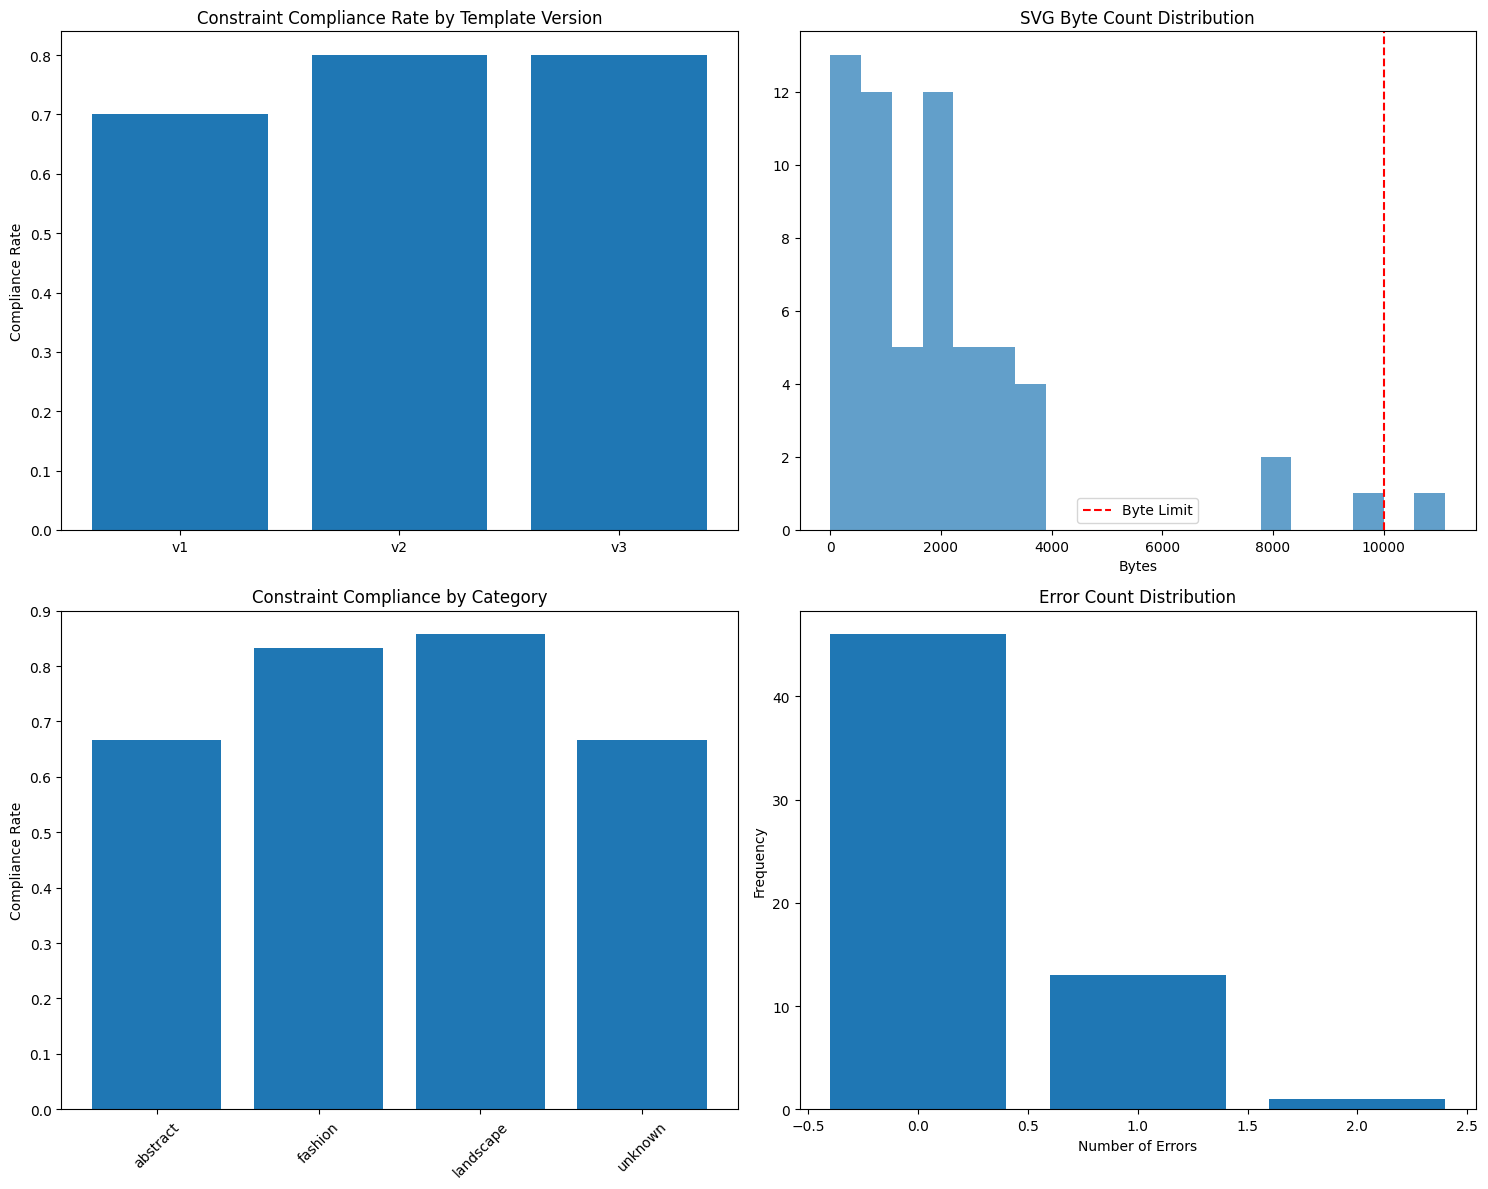


Simulation completed successfully!


In [45]:
main()